In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 20, 20 #width x height in inches

In [7]:
# let's start with normal image and make some predictions

import SimpleITK as sitk
import glob
from tqdm import tqdm


def preprocessing_3d(t1) -> np.ndarray:
    min = 50
    max = 200
    t1 = np.where(t1 < min, min, t1)
    t1 = np.where(t1 > max, max, t1)
    t1 -= min
    return t1 / (max-min)


def label_seperator_liver(img):
    img = np.where(img == 2, 1, img)
    return img


def label_seperator_lesion(img):
    img = np.where(img == 1, 0, img)
    img = np.where(img == 2, 1, img)
    return img


def reading_data(path: str) -> np.ndarray:
    sitk_t1 = sitk.ReadImage(path)
    t1 = sitk.GetArrayFromImage(sitk_t1)
    t1 = t1.reshape(t1.shape[0], t1.shape[1], t1.shape[2], 1)

    t1 = tf.dtypes.cast(t1, tf.float32)

    return t1

def label_seperator_liver(img):
        img = np.where(img == 2, 1, img)
        return img

def z_transform(img_volume, img_seg, param_z=256):
        return_img_volume = np.zeros(
            (param_z, img_volume.shape[1], img_volume.shape[2], img_volume.shape[3])
        )
        return_img_seg = np.zeros(
            (param_z, img_seg.shape[1], img_seg.shape[2], img_seg.shape[3])
        )
        for i in range(img_seg.shape[1]):
            return_img_volume[:, i, :, 0:1] = tf.image.resize(
                img_volume[:, i, :, 0:1], [param_z, 512])
            return_img_seg[:, i, :, 0:1] = tf.image.resize(
                img_seg[:, i, :, 0:1],
                [param_z, 512],
                method="nearest",
            )
        return return_img_volume, return_img_seg


path = "data\\LITS_Challenge\\test\\"
files_volume = glob.glob(path + "\\volume*.nii")
files_segmenation = glob.glob(path + "\\segmentation*.nii")



In [8]:
print(files_volume[0])
print(files_segmenation[0])


no_of_file_to_process = 0

data\LITS_Challenge\test\volume-110.nii
data\LITS_Challenge\test\segmentation-110.nii


In [9]:
volume = reading_data(files_volume[no_of_file_to_process])
gt = reading_data(files_segmenation[no_of_file_to_process])
volume = preprocessing_3d(volume)


print(volume.shape)
trans_v, trans_gt = z_transform(volume, gt, 640) # 640 is the number of slices in the volume działa jak powinno

gt_lession = np.where(gt == 2, 1, 0)

(816, 512, 512, 1)


In [5]:
liver_model = tf.keras.models.load_model(r"C:\Users\kaczm\programming\3DRDNN\models\liver_working_good\05-0.0230.hdf5")
tumor_2d_model = tf.keras.models.load_model(r"C:\Users\kaczm\programming\3DRDNN\models\new_yt_lesion\06-0.0032.hdf5")
tumor_3d_model = tf.keras.models.load_model(r"C:\Users\kaczm\programming\3DRDNN\models\new_yt_3D_lesion\03-0.4084.hdf5")

In [10]:
results_liver = np.zeros((len(volume),256,256,1))
results_lession_2d = np.zeros((len(volume),256,256,1))

threshold = list(np.arange(0.01,0.21,0.01))

#precision_2D = tf.keras.metrics.Precision(thresholds=threshold)
#recall_2D = tf.keras.metrics.Recall(thresholds=threshold)
#precision_2D.reset_states()
#recall_2D.reset_states()

for no_slice in tqdm(range(len(volume))):

    one_resised = tf.reshape(tf.image.resize(volume[no_slice, :, :, 0:1], [256, 256]),(1,256,256,1))
    pred = liver_model.predict(one_resised,verbose = 0)

    t = 0.5
    masked_volume = volume.copy()
    one_resised2 = tf.reshape(tf.image.resize(masked_volume[no_slice, :, :, 0:1], [256, 256]),(1,256,256,1))
    one_resised2 = tf.where(pred > t, one_resised2, 0)
    pred_tumor = tumor_2d_model.predict(one_resised2,verbose = 0)



    gt_resized = tf.reshape(tf.image.resize(gt_lession[no_slice, :, :, 0:1], [256, 256]),(1,256,256,1))

    results_liver[no_slice, :, :, 0:1] = pred[0]
    results_lession_2d[no_slice, :, :, 0:1] = pred_tumor[0]


    #metrics
    #precision_2D.update_state(gt_resized, pred_tumor)
    #recall_2D.update_state(gt_resized, pred_tumor)

100%|██████████| 816/816 [04:09<00:00,  3.27it/s]


In [73]:
#print(f"Prec_2D ={precision_2D.result().numpy()}, recall_2D = {recall_2D.result().numpy()}")

Prec_2D =[0.67215586 0.74092424 0.7777912  0.8034785  0.82450306 0.8396081
 0.8532505  0.8640336  0.87452775 0.88304216 0.8917097  0.898153
 0.9044032  0.9096881  0.9144036  0.9183077  0.92106545 0.92476004
 0.92934257 0.93303365], recall_2D = [0.8328274  0.7858018  0.7509779  0.7254948  0.7022885  0.682877
 0.6654796  0.64942497 0.6351801  0.6225991  0.6100473  0.5990134
 0.5887676  0.5780548  0.56909335 0.5594606  0.5511122  0.5428221
 0.53520346 0.5270886 ]


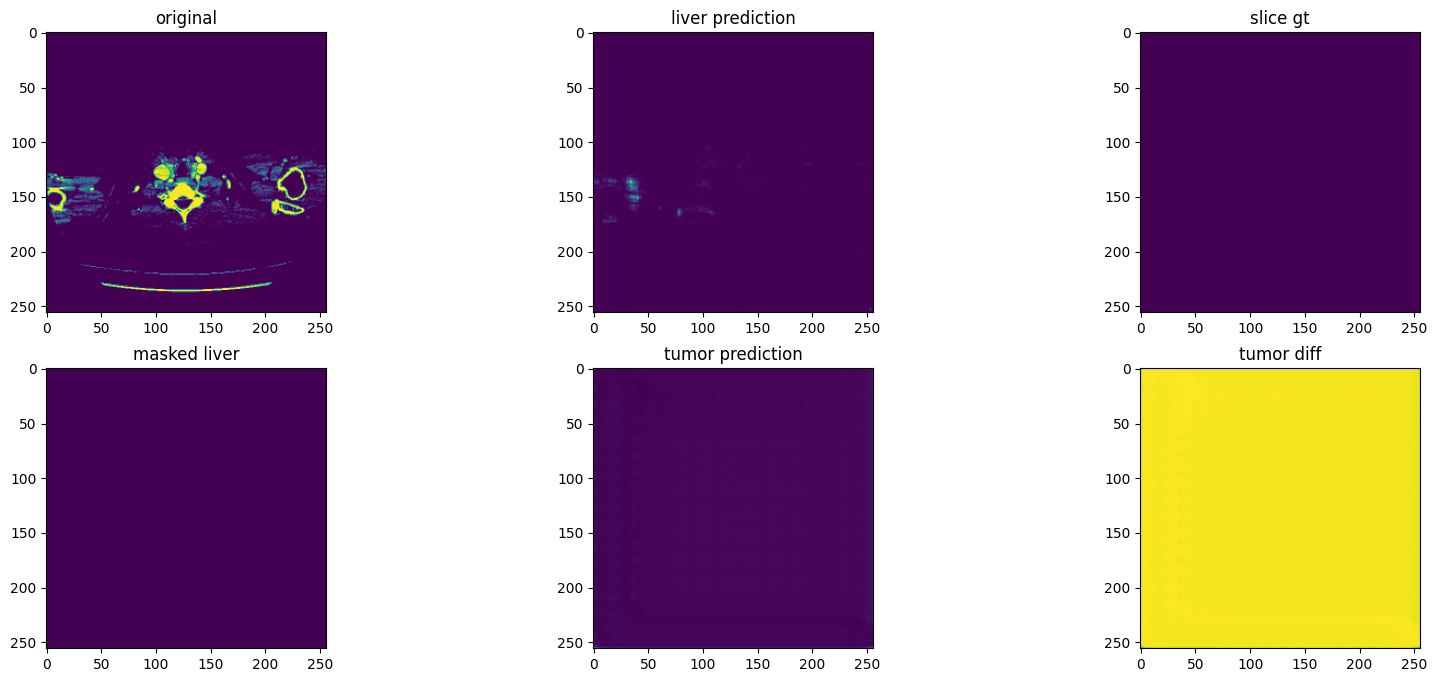

In [11]:



plt.subplot(2,3,1)
plt.title("original")
plt.imshow(one_resised[0,:,:,0])


plt.subplot(2,3,2)
plt.title("liver prediction")
plt.imshow(pred[0,:,:,0])

plt.subplot(2,3,3)
plt.title("slice gt")
plt.imshow(gt_resized[0,:,:,0])

plt.subplot(2,3,4)
plt.title("masked liver")
plt.imshow(one_resised2[0,:,:,0])

plt.subplot(2,3,5)
plt.title("tumor prediction")
plt.imshow(pred_tumor[0,:,:,0])

plt.subplot(2,3,6)
plt.title("tumor diff")
plt.imshow(gt_resized[0,:,:,0] - pred_tumor[0,:,:,0] )
plt.show()


In [12]:
print(np.unique(np.where(results_liver> t,)[0]))
print(np.unique(np.where(results_lession_2d> t,)[0]))
print(np.unique(np.where(gt==1,)[0]))

[305 306 307 308 309 310 311 350 351 352 353 354 355 356 357 358 359 360
 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378
 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396
 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432
 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468
 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486
 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504
 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522
 523 524 525 526 527 528 529 530 531 532]
[398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415
 416 417 418 419 420 421 422 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 

In [13]:
result_3d = np.zeros((volume.shape))
x, y, z = (438, 250, 200)  # starting point


shift_arr = np.arange(-128,129,16)
print(np.min(shift_arr),np.max(shift_arr))
for shift in tqdm(shift_arr):
    for shift_2 in shift_arr:
        for shift_3 in shift_arr:
            one_qube = volume[
                x - 16 + shift : x + 16 + shift,
                y - 16 + shift_2 : y + 16 + shift_2,
                z - 16 + shift_3 : z + 16 + shift_3,
            ]

            one_qube = np.where(gt[
                x - 16 + shift : x + 16 + shift,
                y - 16 + shift_2 : y + 16 + shift_2,
                z - 16 + shift_3 : z + 16 + shift_3,
            ] > 0, one_qube, 0)
            one_qube = one_qube.reshape(1, 32, 32, 32, 1)

            pred_3d = tumor_3d_model.predict(one_qube, verbose=0)
            pred_3d[0] = np.where(gt[
                x - 16 + shift : x + 16 + shift,
                y - 16 + shift_2 : y + 16 + shift_2,
                z - 16 + shift_3 : z + 16 + shift_3,
            ] > 0, pred_3d, 0)
            
            result_3d[
                x - 16 + shift : x + 16 + shift,
                y - 16 + shift_2 : y + 16 + shift_2,
                z - 16 + shift_3 : z + 16 + shift_3,
            ] += pred_3d[0]

-128 128


100%|██████████| 17/17 [04:39<00:00, 16.42s/it]


In [14]:
np.max(result_3d)

7.999963760375977

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


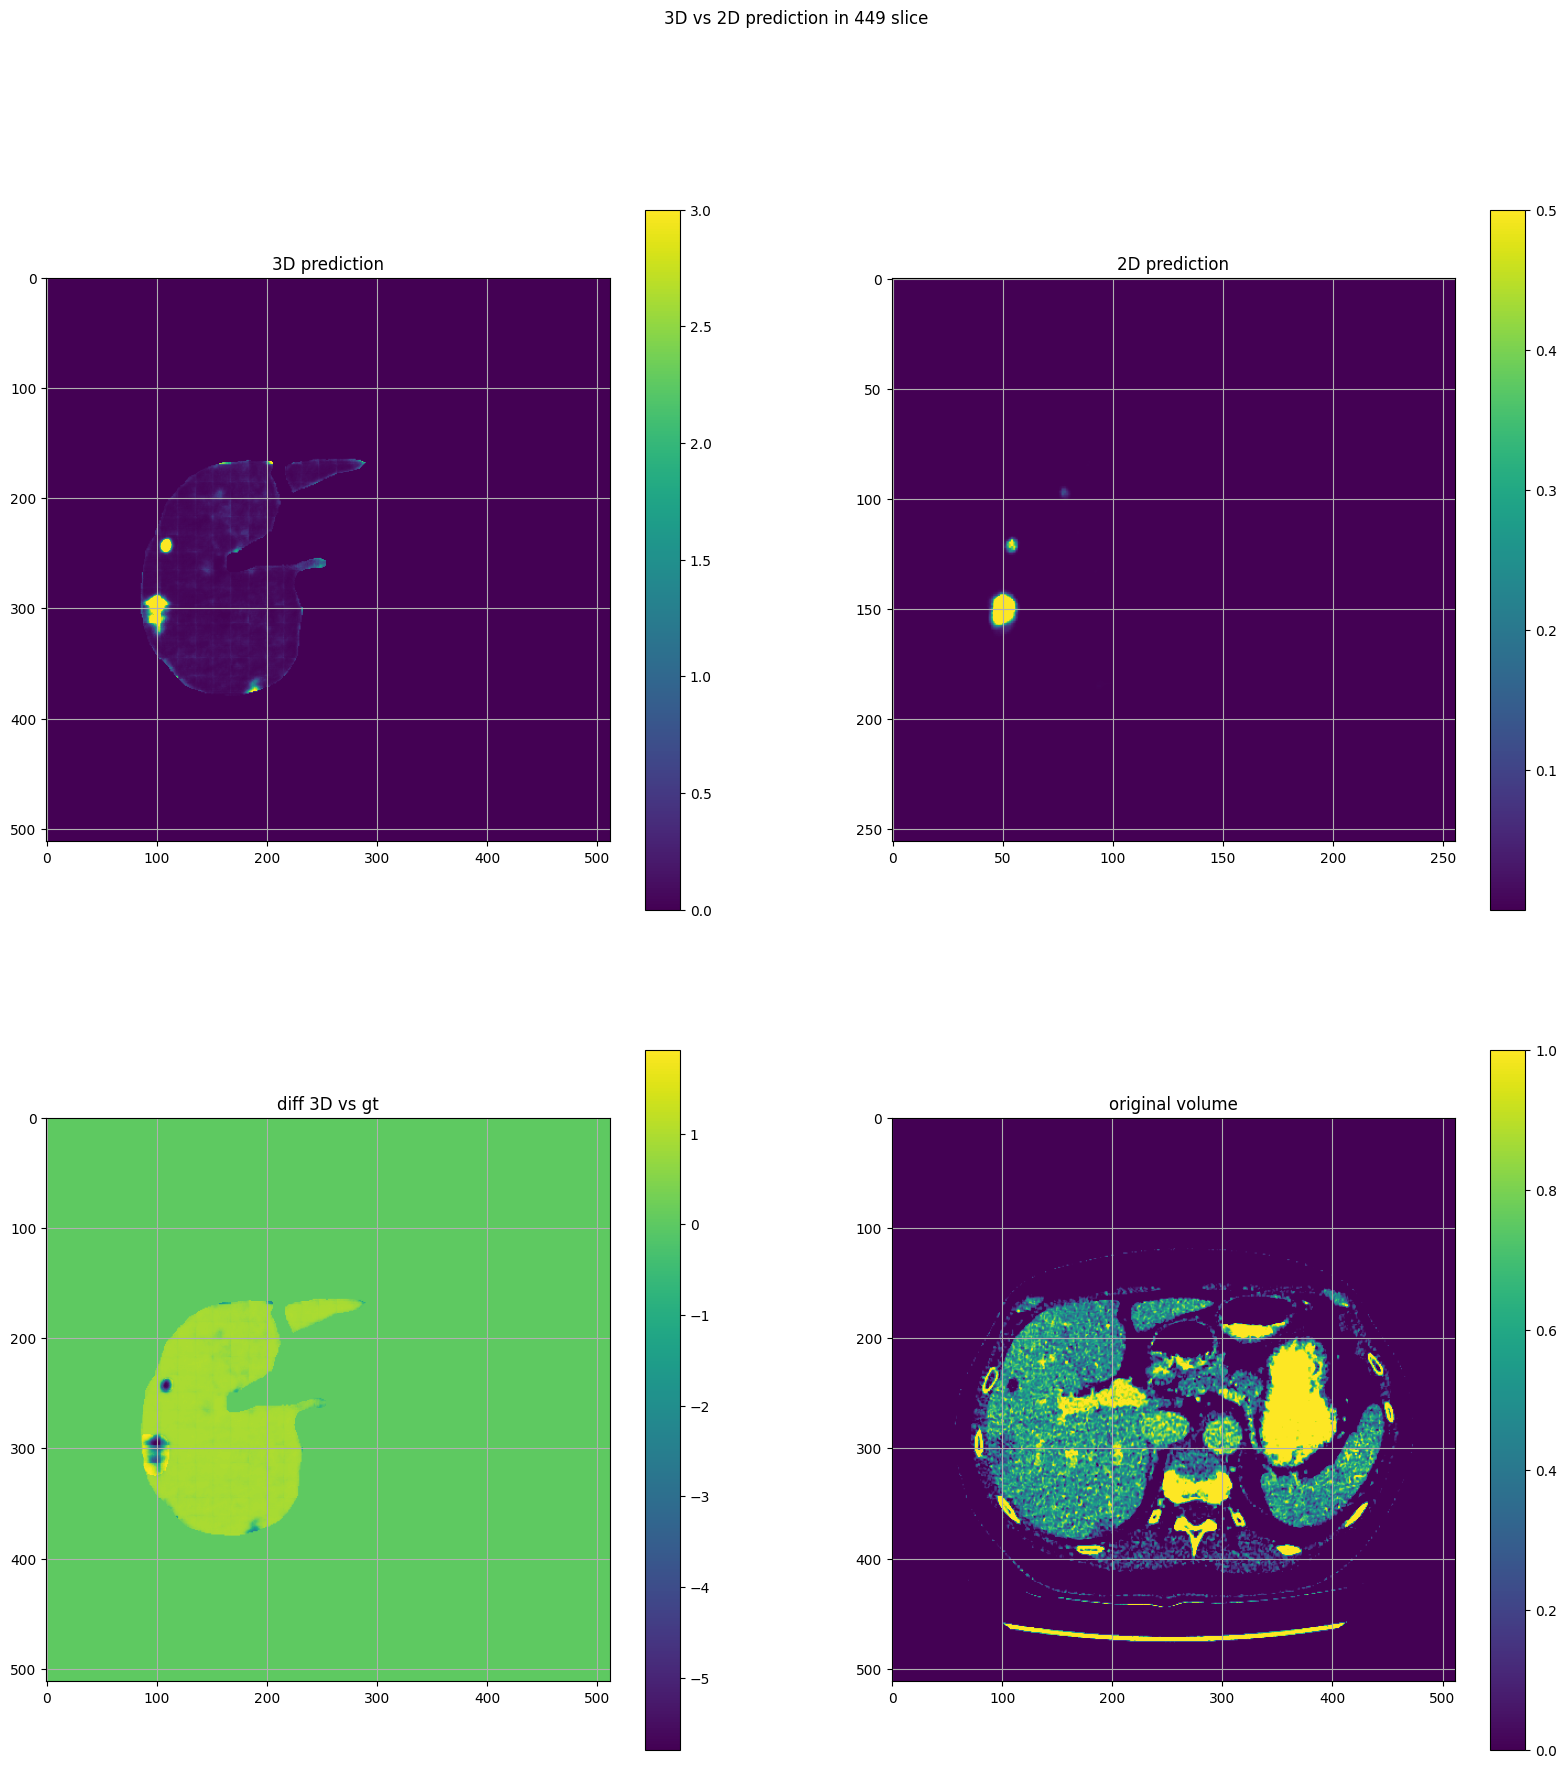

In [23]:
s=395
for s in tqdm(range(350,550,1)):
    plt.suptitle(f"3D vs 2D prediction in {s} slice")
    plt.subplot(2,2,1)
    plt.title("3D prediction")
    plt.imshow(result_3d[s],vmax=3)
    plt.colorbar()
    plt.grid()


    plt.subplot(2,2,2)
    plt.title("2D prediction")
    plt.imshow(results_lession_2d[s],vmax=0.5)
    plt.colorbar()
    plt.grid()


    plt.subplot(2,2,3)
    plt.title("diff 3D vs gt")
    plt.imshow(gt[s]-result_3d[s])
    plt.colorbar()
    plt.grid()

    plt.subplot(2,2,4)
    plt.title("original volume")
    plt.imshow(volume[s])#-result_3d[s]/10)
    plt.colorbar()
    plt.grid()
    plt.savefig(f"output_images/{files_volume[no_of_file_to_process]}_{s}.png")

In [79]:
threshold = 0.35
recall_3D = tf.keras.metrics.Recall(thresholds=threshold)
precision_3D = tf.keras.metrics.Precision(thresholds=threshold)
recall_3D.reset_state()
precision_3D.reset_state()

recall_3D.update_state(gt_lession, np.sqrt(result_3d/np.max(result_3d)))
precision_3D.update_state(gt_lession, np.sqrt(result_3d/np.max(result_3d)))

print(f"Prec_3D {precision_3D.result()}, recall_3D {recall_3D.result()}")

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [44]:
np.sum(result_3d[400]/6)

6372.987118327845

In [41]:
np.sum(trans_gt[400])

23930.0